# Сегментация изображений

В этом ноутбуке будем решать задачу сегментации медицинских снимков. Задачу будем решать с помощью датасета PH2. Датасет состоит из 200 снимков поражений кожи и их сегментированных изображений.

In [1]:
!nvidia-smi

Wed Aug  4 13:26:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>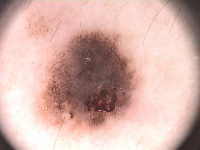</td><td>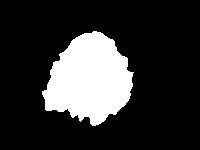</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов поражений кожи: меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [3]:
# Uncomment to download data to the active google drive

# from google.colab import drive
# drive.mount('/content/drive')
#! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
#! wget https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
#! wget https://drive.google.com/file/d/1D3dzsWjU5ghWzRID5dapMu88LBADHflv/view?usp=sharing
#get_ipython().system_raw("unrar x PH2Dataset.rar")
#get_ipython().system_raw("unzip x /content/drive/MyDrive/PH2/PH2Dataset.zip")
#! unzip "/content/drive/MyDrive/PH2/PH2Dataset.zip"

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [6]:
from skimage.io import imread
import os

images = []
lesions = []

#root = "/content/PH2Dataset/" # google drive root
root = "PH2_Dataset" # local root
#'PH2 Dataset images'

for root, dirs, files in os.walk(os.path.join(root, 'PH2_Dataset')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [8]:
from skimage.transform import resize

size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [9]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

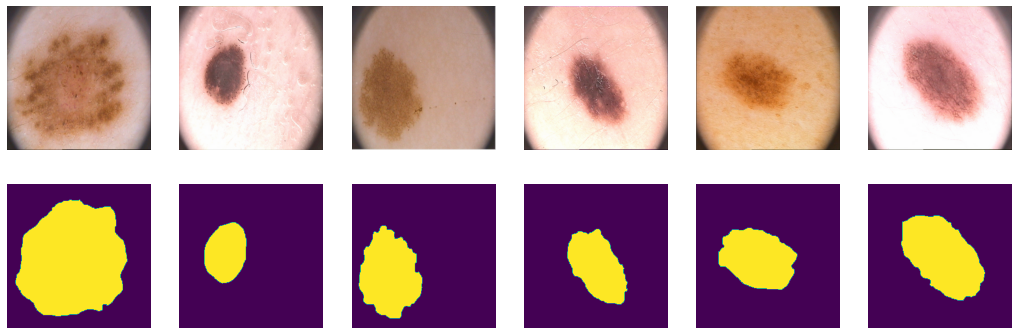

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно. Для этого реализуем функцию, которая будет возвращать загрузчики данных для тренировки, валидации и теста с заданным размером батча.

#### PyTorch DataLoader

In [11]:
from torch.utils.data import DataLoader

def create_dataloader(X, Y, batch_size):
    ix = np.random.choice(len(X), len(X), False)
    tr, val, ts = np.split(ix, [100, 150])
    batch_size = batch_size
    data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                         batch_size=batch_size, shuffle=True)
    data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                          batch_size=batch_size, shuffle=True)
    data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                         batch_size=batch_size, shuffle=True)
    
    return data_tr, data_val, data_ts

Обучение будем выполнять с использованием GPU.

In [12]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Реализуем несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравним их по качеству на тесте и попробуем различные функции потерь на них.

-----------------------------------------------------------------------------------------

# SegNet

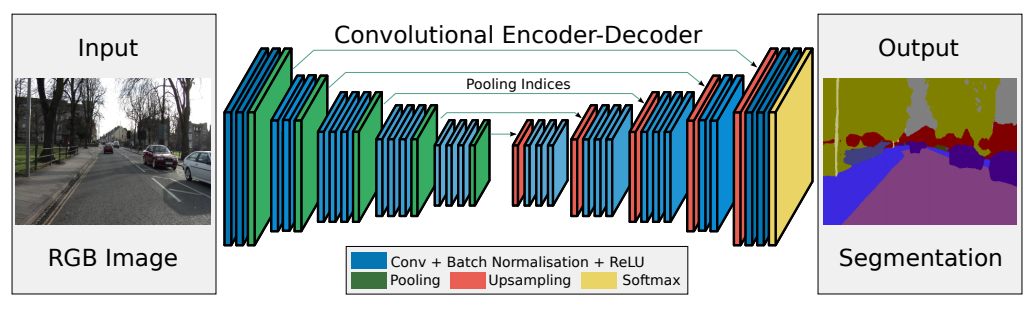

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Архитектура сети состоит из энкодера, ботлнека и декодера. В энкодере используются несколько сверточных слоев с даунсемплингом:
<br>
**Conv2d > ReLU > BatchNorm2d > MaxPool2d**
<br>
На выходе энкодера получаем карты активации с вероятностями принадлежности пикселей к определенному классу. В нашем случае это вероятность того принадлежит ли пиксель поражению кожи или нет. Промежуточным слоем между энкодером и декодером является ботлнэк. Далее декодер восстанавливает сегментированное изображение из полученных карт активации. Декодер также состоит из сверточных слоев и апсемплинга:
<br>
**Conv2d > ReLU > BatchNorm2d > Upsample**
<br>
Также отличительной особенностью **Segnet** является передача индексов пулинга в соответствующие слои декодера для апсемплинга.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
import pandas as pd
from matplotlib import rcParams

rcParams['figure.figsize'] = (15,4)

In [14]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True)   # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16
        

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512)
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )
        
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )
        
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
        )
        
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
        )
        
        

    def forward(self, x):
        # encoder
        x = self.enc_conv0(x)
        x, indices0 = self.pool0(x) # 256 -> 128
        x = self.enc_conv1(x)
        x, indices1 = self.pool1(x) # 128 -> 64
        x = self.enc_conv2(x)
        x, indices2 = self.pool2(x) # 64 -> 32
        x = self.enc_conv3(x)
        x, indices3 = self.pool3(x) # 32 -> 16

        # bottleneck
        x = self.bottleneck_conv(x) 

        # decoder
        print(indices.size())
        x = self.upsample0(x)
        x = self.dec_conv0(x)
        x = self.upsample1(x)
        x = self.dec_conv1(x)
        x = self.upsample2(x)
        x = self.dec_conv2(x)
        x = self.upsample3(x)
        x =  self.dec_conv3(x)
        
        return x

In [15]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True)   # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16
        

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512)
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )
        
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )
        
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
        )
        
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
        )
        
        

    def forward(self, x):
        # encoder
        x = self.enc_conv0(x)
        x, indices0 = self.pool0(x) # 256 -> 128
        x = self.enc_conv1(x)
        x, indices1 = self.pool1(x) # 128 -> 64
        x = self.enc_conv2(x)
        x, indices2 = self.pool2(x) # 64 -> 32
        x = self.enc_conv3(x)
        x, indices3 = self.pool3(x) # 32 -> 16

        # bottleneck
        x = self.bottleneck_conv(x) 

        # decoder
        x = self.upsample0(x, indices3)  # 16 -> 32
        x = self.dec_conv0(x)
        x = self.upsample1(x, indices2) # 32 -> 64
        x = self.dec_conv1(x)
        x = self.upsample2(x, indices1) # 64 -> 128
        x = self.dec_conv2(x)
        x = self.upsample3(x, indices0) # 128 -> 256
        x =  self.dec_conv3(x)
        
        return x

## Метрика

Для оценки качества будем использовать следующую метрику:

$$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [16]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH) # We smooth our devision to avoid 0/0
    
    return iou

## Функция потерь

Не менее важным, чем построение архитектуры, является определение оптимизатора и функции потерь.

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [17]:
def bce_loss(y_pred, y_real):
    y_pred = torch.clip(y_pred, 1e-7, 1 - 1e-7)
    
    return torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))

## Тренировка
Реализуем цикл обучения для наших будущих моделей:

In [18]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    train_loss = []
    eval_loss = []
    iou_scores = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model.forward(X_batch) # forward-pass
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward() # backward-pass
            opt.step() # update weights
            avg_loss += loss.detach().cpu() / len(data_tr) # calculate loss to show the user
            
        train_loss.append(avg_loss.item())
        
        toc = time()

        # show intermediate results
        model.eval()  # testing mode
        avg_val_loss = 0
        iou_score = 0
        
        with torch.no_grad():
            for X_val, Y_val in data_val:
                X_val = X_val.to(device)
                Y_val = Y_val.to(device)
                Y_pred = model(X_val)
                Y_pred = torch.sigmoid(Y_pred)
                Y_pred[Y_pred > 0.5] = 1
                loss = loss_fn(Y_pred, Y_val)
                avg_val_loss += loss.detach().cpu() / len(data_val)
                iou_score += iou_pytorch(Y_pred, Y_val).mean().detach().cpu() / len(data_val) #calculate iou score
                
            eval_loss.append(avg_val_loss.item())
            iou_scores.append(iou_score.item())
            
        X_val = X_val.detach().cpu()
        Y_val = Y_val.detach().cpu() 
        Y_pred = Y_pred.detach().cpu()

        # Visualize tools
        clear_output(wait=True)
        
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')
            
            plt.subplot(3, 6, k+7)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('Mask')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_pred[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
            
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_val_loss))
        plt.show()
    
    return train_loss, eval_loss, iou_scores

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [19]:
def score_model(model, metric, epochs, data):
    
    with torch.no_grad():
        model.eval()
        scores = 0
            
        for X_batch, Y_label in data:
            X_batch = X_batch.to(device)
            Y_label = Y_label.to(device)
            Y_pred = model(X_batch)
            Y_pred = torch.sigmoid(Y_pred)
            Y_pred[Y_pred > 0.5] = 1
            scores += (metric(Y_pred, Y_label).mean().item())

    return scores / len(data)

## Обучение
Обучать нашу модель будем с использованием загрузчиков данных с batch_size = 25. В качестве оптимизатора будем использовать 
Adam с learning rate = 0.0001. Количество циклов обучения определяется параметром max_epochs. В нашем, случае он равен 100.
Как функцию потерь будем использовать BCE.

In [20]:
train_results = pd.DataFrame()
scores_results = pd.DataFrame()

train_results.to_csv("train_results.csv")
scores_results.to_csv("scores_results.csv")

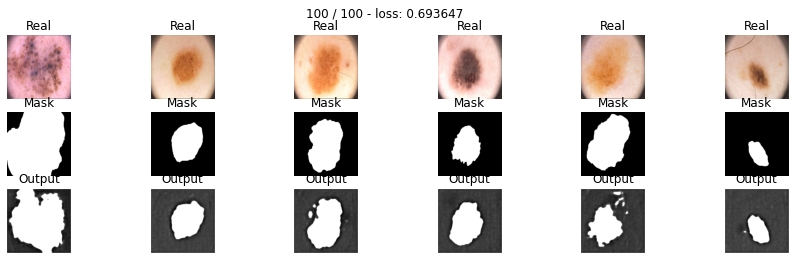

In [21]:
data_tr, data_val, data_ts = create_dataloader(X, Y, 25)

segnet_bce = SegNet().to(device)
optimizer = optim.Adam(segnet_bce.parameters(), lr=0.0001)
max_epochs = 100
segnet_bce_train_loss, segnet_bce_eval_loss, segnet_bce_iou_score = train(segnet_bce, optimizer,
                                                                          bce_loss, max_epochs, data_tr, data_val)

train_results["segnet_bce_train_loss"] = segnet_bce_train_loss
train_results["segnet_bce_eval_loss"] = segnet_bce_eval_loss
train_results["segnet_bce_iou_score"] = segnet_bce_iou_score
train_results.to_csv("train_results.csv")

Построим график функции потерь на тренировочной и валидационной выборках данных:

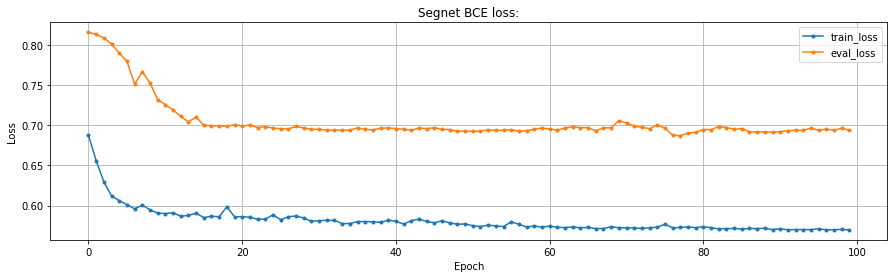

In [22]:
plt.title("Segnet BCE loss:")
plt.plot(segnet_bce_train_loss, label="train_loss", marker=".")
plt.plot(segnet_bce_eval_loss, label="eval_loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

Спрогнозируем точность нашей модели на тестовой выборке:

In [23]:
segnet_bce_test_score = score_model(segnet_bce, iou_pytorch, max_epochs, data_ts)

scores_results["segnet_bce_test_score"] = [segnet_bce_test_score]
scores_results.to_csv("scores_results.csv")
print("Segnet model with bce loss score: ", segnet_bce_test_score)

Segnet model with bce loss score:  0.8772720992565155


-----------------------------------------------------------------------------------------

## Дополнительные функции потерь

Имплементируем две дополнительные функции потерь: DICE и Focal loss.

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

In [24]:
def dice_loss(y_pred, y_real):
    y_pred = torch.clip(y_pred, 1e-7, 1 - 1e-7)
    y_real = y_real.view(-1)
    y_pred = y_pred.view(-1)
    num = (y_real * y_pred).sum()
    den = y_real.sum() + y_pred.sum()
    res = 1 - 2 * (num) / (den)
    
    return res

Проводим тестирование:

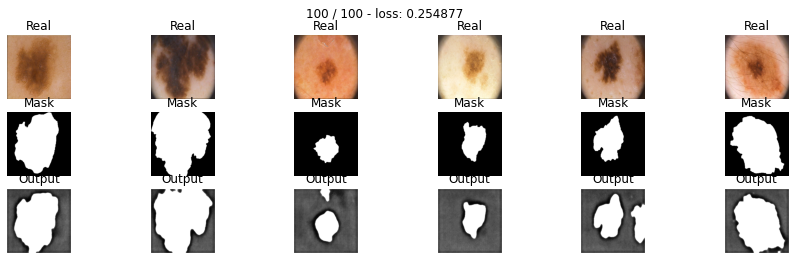

In [25]:
data_tr, data_val, data_ts = create_dataloader(X, Y, 25)

segnet_dice = SegNet().to(device)
max_epochs = 100
optimizer = optim.Adam(segnet_dice.parameters(), lr=0.0001)
segnet_dice_train_loss, segnet_dice_eval_loss, segnet_dice_iou_score = train(segnet_dice, optimizer,
                                                                              dice_loss, max_epochs, data_tr, data_val)
train_results = pd.read_csv("train_results.csv")
train_results["segnet_dice_train_loss"] = segnet_dice_train_loss
train_results["segnet_dice_eval_loss"] = segnet_dice_eval_loss
train_results["segnet_dice_iou_score"] = segnet_dice_iou_score
train_results.to_csv("train_results.csv")

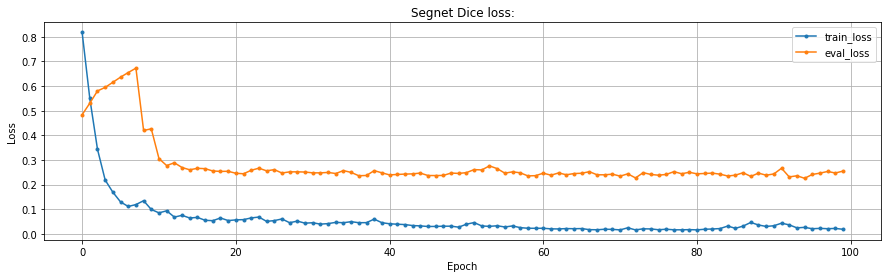

In [26]:
plt.title("Segnet Dice loss:")
plt.plot(segnet_dice_train_loss, label="train_loss", marker=".")
plt.plot(segnet_dice_eval_loss, label="eval_loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

In [27]:
segnet_dice_test_score = score_model(segnet_dice, iou_pytorch, max_epochs, data_ts)

scores_results = pd.read_csv("scores_results.csv")
scores_results["segnet_dice_test_score"] = [segnet_dice_test_score]
scores_results.to_csv("scores_results.csv")
print("Segnet model with dice loss score: ", segnet_dice_test_score)

Segnet model with dice loss score:  0.8511441051959991


[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу большинства (фоновому) по отношению к классу меньшинства (переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [28]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    y_pred = torch.clip(y_pred, eps, 1 - eps)
    bce = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))
    pt = torch.exp(-bce)
    focal = (1 - pt) ** gamma * bce

    return torch.mean(focal)

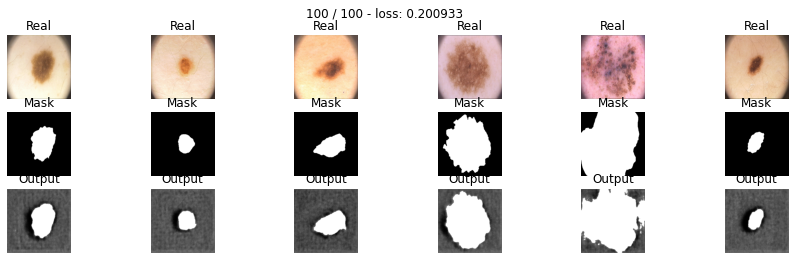

In [29]:
data_tr, data_val, data_ts = create_dataloader(X, Y, 10)

segnet_focal = SegNet().to(device)
max_epochs = 100
optimizer = optim.Adam(segnet_focal.parameters(), lr=0.0001)
segnet_focal_train_loss, segnet_focal_eval_loss, segnet_focal_iou_score = train(segnet_focal, optimizer,
                                                                                focal_loss, max_epochs, data_tr, data_val)

train_results = pd.read_csv("train_results.csv")
train_results["segnet_focal_train_loss"] = segnet_focal_train_loss
train_results["segnet_focal_eval_loss"] = segnet_focal_eval_loss
train_results["segnet_focal_iou_score"] = segnet_focal_iou_score
train_results.to_csv("train_results.csv")

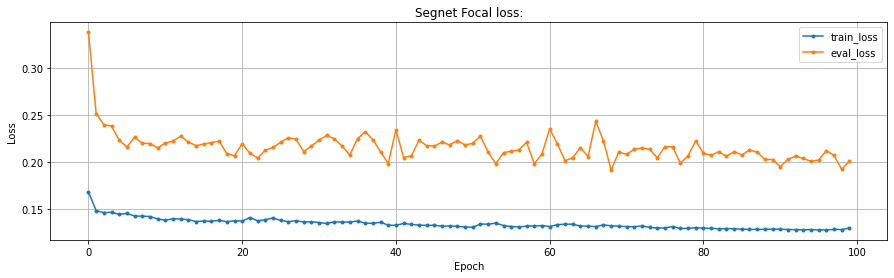

In [30]:
plt.title("Segnet Focal loss:")
plt.plot(segnet_focal_train_loss, label="train_loss", marker=".")
plt.plot(segnet_focal_eval_loss, label="eval_loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

In [31]:
segnet_focal_test_score = score_model(segnet_focal, iou_pytorch, max_epochs, data_ts)

scores_results = pd.read_csv("scores_results.csv")
scores_results["segnet_focal_test_score"] = [segnet_focal_test_score]
scores_results.to_csv("scores_results.csv")
print("Segnet model with focal loss score: ", segnet_focal_test_score)

Segnet model with focal loss score:  0.8671290278434753


-----------------------------------------------------------------------------------------

# U-Net
[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

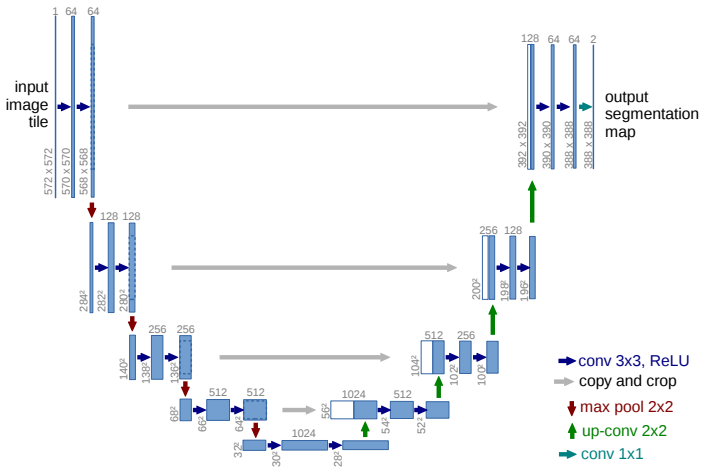

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [32]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        ) 
        self.pool0 = nn.MaxPool2d(kernel_size=2)   # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
        )


        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)   # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        
        self.upsample1 = nn.Upsample(scale_factor=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )
        
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )
        
        self.upsample3 = nn.Upsample(scale_factor=2)   # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=1),
        )

    def forward(self, x):
        # encoder
        enc0 = self.enc_conv0(x)
        pool0 = self.pool0(enc0)
        enc1 = self.enc_conv1(pool0)
        pool1 = self.pool1(enc1)
        enc2 = self.enc_conv2(pool1)
        pool2 = self.pool2(enc2)
        enc3 = self.enc_conv3(pool2)
        pool3 = self.pool3(enc3)

        # bottleneck
        btnck = self.bottleneck_conv(pool3)

        # decoder
        upsamp0 = self.upsample0(btnck)
        dec0 = self.dec_conv0(upsamp0 + enc3)
        upsamp1 = self.upsample1(dec0)
        dec1 = self.dec_conv1(upsamp1 + enc2)
        upsamp2 = self.upsample2(dec1)
        dec2 = self.dec_conv2(upsamp2 + enc1)
        upsamp3 = self.upsample3(dec2)
        dec3 = self.dec_conv3(upsamp3 + enc0)

        return dec3

Аналогично **SegNet** обучим нашу модель с функциями потерь **BCE, Dice, Focal**.

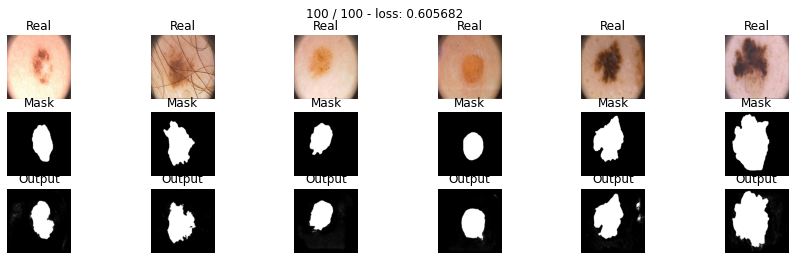

In [33]:
data_tr, data_val, data_ts = create_dataloader(X, Y, 10)
max_epochs = 100
unet_bce = UNet().to(device)
optimizer = optim.Adam(unet_bce.parameters(), lr=0.0001)
unet_bce_train_loss, unet_bce_eval_loss, unet_bce_iou_score = train(unet_bce, optimizer,
                                                                    bce_loss, max_epochs, data_tr, data_val)
train_results = pd.read_csv("train_results.csv")
train_results["unet_bce_train_loss"] = unet_bce_train_loss
train_results["unet_bce_eval_loss"] = unet_bce_eval_loss
train_results["unet_bce_iou_score"] = unet_bce_iou_score
train_results.to_csv("train_results.csv")

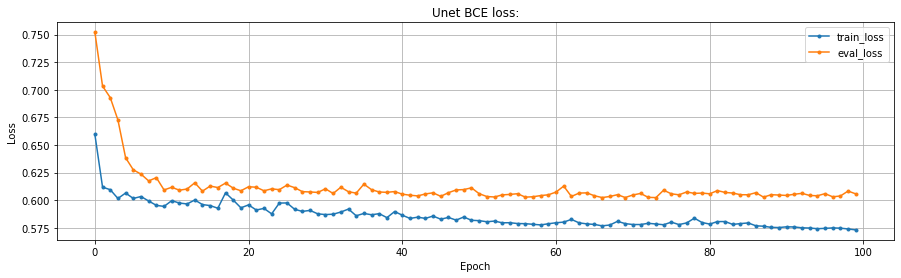

In [34]:
plt.title("Unet BCE loss:")
plt.plot(unet_bce_train_loss, label="train_loss", marker=".")
plt.plot(unet_bce_eval_loss, label="eval_loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

In [35]:
unet_bce_test_score  = score_model(unet_bce, iou_pytorch, max_epochs, data_ts)

scores_results = pd.read_csv("scores_results.csv")
scores_results["unet_bce_test_score"] = [unet_bce_test_score]
scores_results.to_csv("scores_results.csv")
print("Unet model with BCE loss score: ", unet_bce_test_score)

Unet model with BCE loss score:  0.8660197854042053


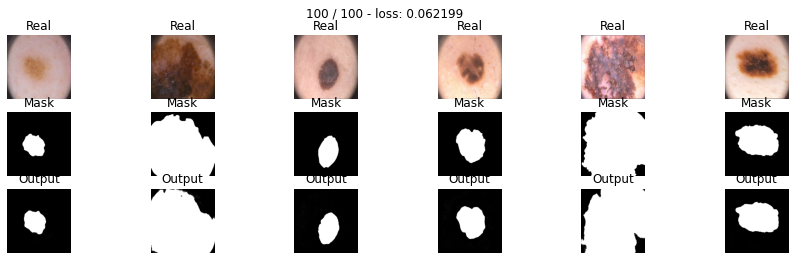

In [36]:
data_tr, data_val, data_ts = create_dataloader(X, Y, 10)
max_epochs = 100
unet_dice = UNet().to(device)
optimizer = optim.Adam(unet_dice.parameters(), lr=0.0001)
unet_dice_train_loss, unet_dice_eval_loss, unet_dice_iou_score = train(unet_dice, optimizer,
                                                                       dice_loss, max_epochs, data_tr, data_val)

train_results = pd.read_csv("train_results.csv")
train_results["unet_dice_train_loss"] = unet_dice_train_loss
train_results["unet_dice_eval_loss"] = unet_dice_eval_loss
train_results["unet_dice_iou_score"] = unet_dice_iou_score
train_results.to_csv("train_results.csv")

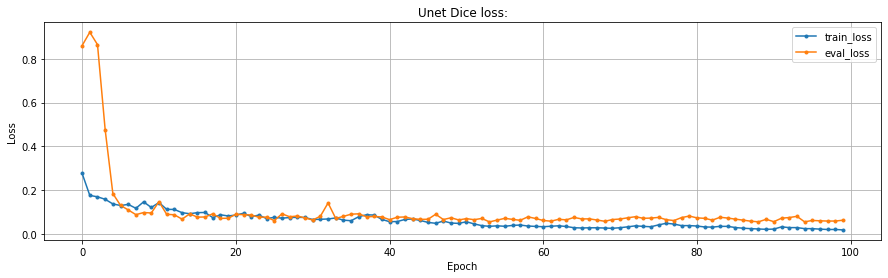

In [37]:
plt.title("Unet Dice loss:")
plt.plot(unet_dice_train_loss, label="train_loss", marker=".")
plt.plot(unet_dice_eval_loss, label="eval_loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

In [38]:
unet_dice_test_score = score_model(unet_dice, iou_pytorch, max_epochs, data_ts)

scores_results = pd.read_csv("scores_results.csv")
scores_results["unet_dice_test_score"] = [unet_dice_test_score]
scores_results.to_csv("scores_results.csv")
print("Unet model with Dice loss score: ", unet_dice_test_score)

Unet model with Dice loss score:  0.8265118598937988


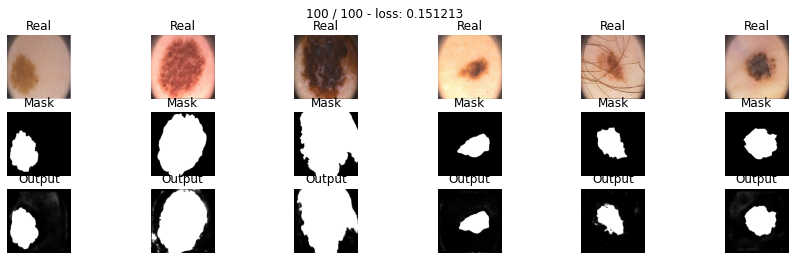

In [39]:
data_tr, data_val, data_ts = create_dataloader(X, Y, 10)
max_epochs = 100
unet_focal = UNet().to(device)
optimizer = optim.Adam(unet_focal.parameters(), lr=0.0001)
unet_focal_train_loss, unet_focal_eval_loss, unet_focal_iou_score = train(unet_focal, optimizer,
                                                                          focal_loss, max_epochs, data_tr, data_val)
train_results = pd.read_csv("train_results.csv")
train_results["unet_focal_train_loss"] = unet_focal_train_loss
train_results["unet_focal_eval_loss"] = unet_focal_eval_loss
train_results["unet_focal_iou_score"] = unet_focal_iou_score
train_results.to_csv("train_results.csv")

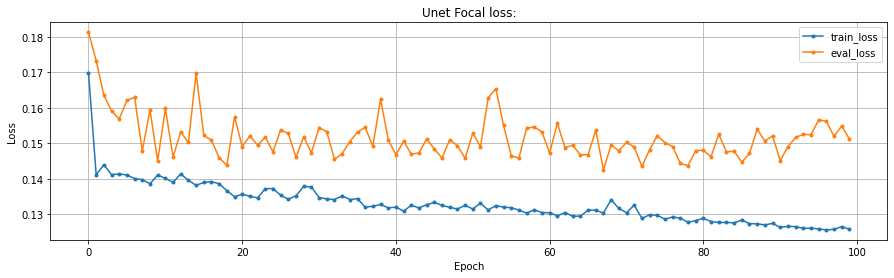

In [40]:
plt.title("Unet Focal loss:")
plt.plot(unet_focal_train_loss, label="train_loss", marker=".")
plt.plot(unet_focal_eval_loss, label="eval_loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

In [41]:
unet_focal_test_score = score_model(unet_dice, iou_pytorch, max_epochs, data_ts)

scores_results = pd.read_csv("scores_results.csv")
scores_results["unet_focal_test_score"] = [unet_focal_test_score]
scores_results.to_csv("scores_results.csv")
print("Unet model with Focal loss score: ", unet_focal_test_score)

Unet model with Focal loss score:  0.8894276976585388


Новая модель путем изменения типа пулинга:
<br>

Заменим max-pooling на convolutions с kernel_size = 1 и padding = 2, а upsampling на transpose-convolutions с kernel_size = 2 stride=2.


In [42]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )
        self.pool0 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=2)   # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )
        self.pool1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=2)  # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        self.pool2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=2)  # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
        )
        self.pool3 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1, stride=2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=1024, out_channels=1024, kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        
        self.upsample1 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )
        
        self.upsample2 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )
        
        self.upsample3 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)   # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=1),
        )

    def forward(self, x):
        # encoder
        enc0 = self.enc_conv0(x)
        pool0 = self.pool0(enc0)
        enc1 = self.enc_conv1(pool0)
        pool1 = self.pool1(enc1)
        enc2 = self.enc_conv2(pool1)
        pool2 = self.pool2(enc2)
        enc3 = self.enc_conv3(pool2)
        pool3 = self.pool3(enc3)

        # bottleneck
        btnck = self.bottleneck_conv(pool3)

        # decoder
        upsamp0 = self.upsample0(btnck)
        dec0 = self.dec_conv0(upsamp0 + enc3)
        upsamp1 = self.upsample1(dec0)
        dec1 = self.dec_conv1(upsamp1 + enc2)
        upsamp2 = self.upsample2(dec1)
        dec2 = self.dec_conv2(upsamp2 + enc1)
        upsamp3 = self.upsample3(dec2)
        dec3 = self.dec_conv3(upsamp3 + enc0)

        return dec3

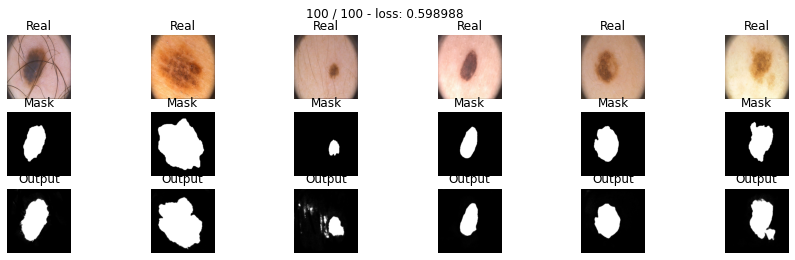

In [43]:
data_tr, data_val, data_ts = create_dataloader(X, Y, 10)
unet2_bce = UNet2().to(device)
max_epochs = 100
optimizer = optim.Adam(unet2_bce.parameters(), lr=0.0001)
unet2_bce_train_loss, unet2_bce_eval_loss, unet2_bce_iou_score = train(unet2_bce, optimizer,
                                                  bce_loss, max_epochs, data_tr, data_val)

train_results = pd.read_csv("train_results.csv")
train_results["unet2_bce_train_loss"] = unet2_bce_train_loss
train_results["unet2_bce_eval_loss"] = unet2_bce_eval_loss
train_results["unet2_bce_iou_score"] = unet2_bce_iou_score
train_results.to_csv("train_results.csv")

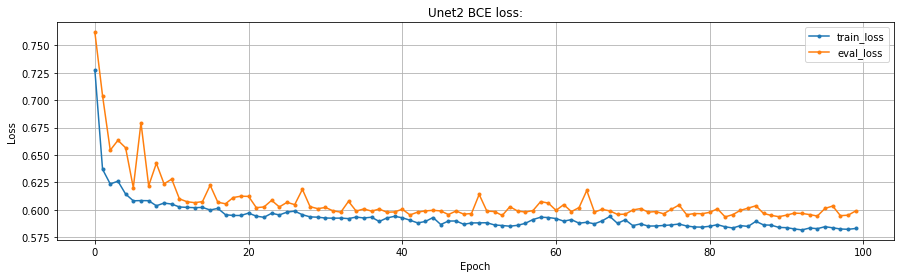

In [44]:
plt.title("Unet2 BCE loss:")
plt.plot(unet2_bce_train_loss, label="train_loss", marker=".")
plt.plot(unet2_bce_eval_loss, label="eval_loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

In [45]:
unet2_bce_test_score = score_model(unet2_bce, iou_pytorch, max_epochs, data_ts)

scores_results = pd.read_csv("scores_results.csv")
scores_results["unet2_bce_test_score"] = [unet2_bce_test_score]
scores_results.to_csv("scores_results.csv")
print("Unet2 model with BCE loss score: ", unet2_bce_test_score)

Unet2 model with BCE loss score:  0.8530789375305176


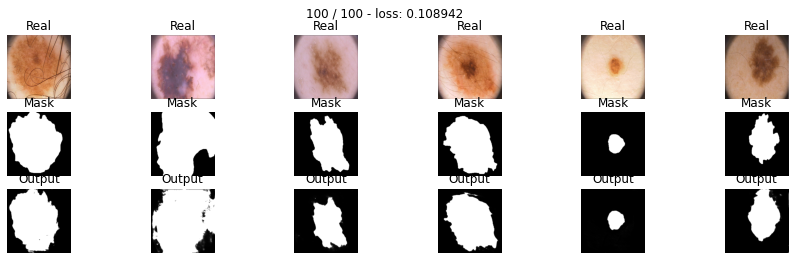

In [46]:
data_tr, data_val, data_ts = create_dataloader(X, Y, 10)
unet2_dice = UNet2().to(device)
max_epochs = 100
optimizer = optim.Adam(unet2_dice.parameters(), lr=0.0001)
unet2_dice_train_loss, unet2_dice_eval_loss, unet2_dice_iou_score = train(unet2_dice, optimizer,
                                                  dice_loss, max_epochs, data_tr, data_val)

train_results = pd.read_csv("train_results.csv")
train_results["unet2_dice_train_loss"] = unet2_dice_train_loss
train_results["unet2_dice_eval_loss"] = unet2_dice_eval_loss
train_results["unet2_dice_iou_score"] = unet2_dice_iou_score
train_results.to_csv("train_results.csv")

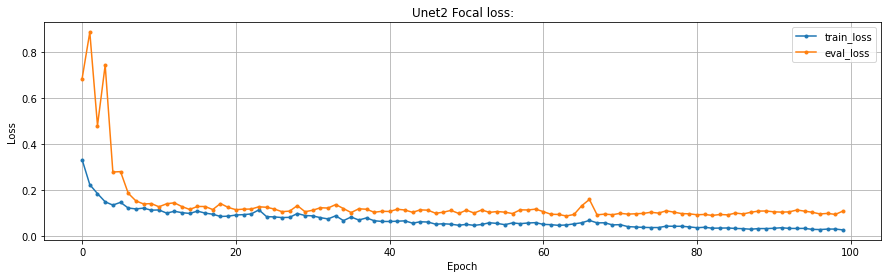

In [47]:
plt.title("Unet2 Focal loss:")
plt.plot(unet2_dice_train_loss, label="train_loss", marker=".")
plt.plot(unet2_dice_eval_loss, label="eval_loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

In [48]:
unet2_dice_test_score = score_model(unet2_dice, iou_pytorch, max_epochs, data_ts)

scores_results = pd.read_csv("scores_results.csv")
scores_results["unet2_dice_test_score"] = [unet2_dice_test_score]
scores_results.to_csv("scores_results.csv")
print("Unet2 model with Dice loss score: ", unet2_dice_test_score)

Unet2 model with Dice loss score:  0.874285626411438


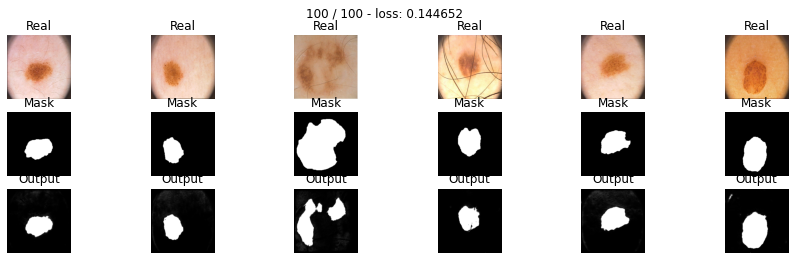

In [49]:
data_tr, data_val, data_ts = create_dataloader(X, Y, 10)
unet2_focal = UNet2().to(device)
max_epochs = 100
optimizer = optim.Adam(unet2_focal.parameters(), lr=0.0001)
unet2_focal_train_loss, unet2_focal_eval_loss, unet2_focal_iou_score = train(unet2_focal, optimizer,
                                                  focal_loss, max_epochs, data_tr, data_val)

train_results = pd.read_csv("train_results.csv")
train_results["unet2_focal_train_loss"] = unet2_focal_train_loss
train_results["unet2_focal_eval_loss"] = unet2_focal_eval_loss
train_results["unet2_focal_iou_score"] = unet2_focal_iou_score
train_results.to_csv("train_results.csv")

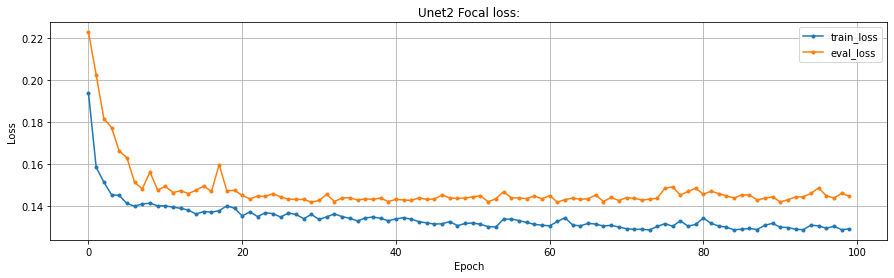

In [50]:
plt.title("Unet2 Focal loss:")
plt.plot(unet2_focal_train_loss, label="train_loss", marker=".")
plt.plot(unet2_focal_eval_loss, label="eval_loss", marker=".")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

In [51]:
unet2_focal_test_score = score_model(unet2_focal, iou_pytorch, max_epochs, data_ts)

scores_results = pd.read_csv("scores_results.csv")
scores_results["unet2_focal_test_score"] = [unet2_focal_test_score]
scores_results.to_csv("scores_results.csv")
print("Unet2 model with Focal loss score: ", unet2_focal_test_score)

Unet2 model with Focal loss score:  0.7856417298316956


Сделайте вывод, какая из моделей лучше

# Отчет

Построим графики функций потерь, полученных при обучении и валидации. На графике видно, что разные модели при использовании одинаковых функций потерь имеют примерно одинаковые значения потерь на разных этапах обучения. Особенно выделяются модели с **BCE**, которые имеют большие значения потерь на обучении. Лучше всех с обучением справились модели для обучения которых, использовалься функция потерь **Dice**.

In [52]:
train_results = pd.read_csv("train_results.csv")
scores_results = pd.read_csv("scores_results.csv")

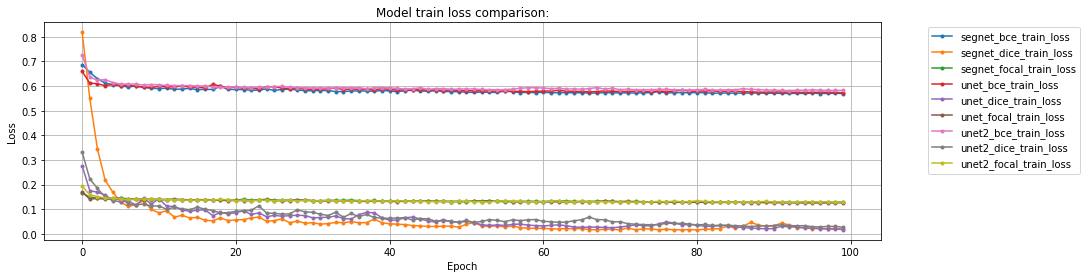

In [53]:
segnet_bce_train_loss = train_results["segnet_bce_train_loss"]
segnet_dice_train_loss = train_results["segnet_dice_train_loss"]
segnet_focal_train_loss = train_results["segnet_focal_train_loss"]
unet_bce_train_loss = train_results["unet_bce_train_loss"]
unet_dice_train_loss = train_results["unet_dice_train_loss"]
unet_focal_train_loss = train_results["unet_focal_train_loss"]
unet2_bce_train_loss = train_results["unet2_bce_train_loss"]
unet2_dice_train_loss = train_results["unet2_dice_train_loss"]
unet2_focal_train_loss = train_results["unet2_focal_train_loss"]

train_losses = {"segnet_bce_train_loss" : segnet_bce_train_loss, 
                "segnet_dice_train_loss" : segnet_dice_train_loss,
                "segnet_focal_train_loss" : segnet_focal_train_loss, 
                "unet_bce_train_loss" : unet_bce_train_loss,
                "unet_dice_train_loss" : unet_dice_train_loss, 
                "unet_focal_train_loss" : unet_focal_train_loss, 
                "unet2_bce_train_loss" : unet2_bce_train_loss, 
                "unet2_dice_train_loss" : unet2_dice_train_loss, 
                "unet2_focal_train_loss" : unet2_focal_train_loss
               }

for key, val in train_losses.items():
    plt.plot(val, label=key, marker=".")

plt.title("Model train loss comparison:")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')    
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Аналогичную картину видим и при валидации. Модели, для валидации которых использовались одинаковые функции потерь имеют примерно одни и те же значения потерь.
Также видим, что самые низкие значения потерь имеют модели с функцией потерь **Dice**.

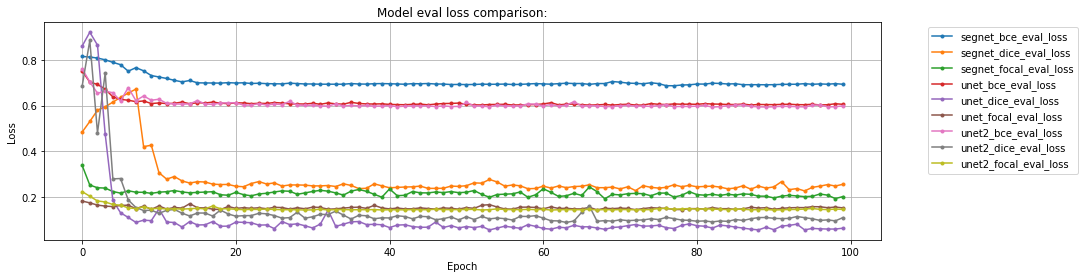

In [54]:
segnet_bce_eval_loss = train_results["segnet_bce_eval_loss"]
segnet_dice_eval_loss = train_results["segnet_dice_eval_loss"]
segnet_focal_eval_loss = train_results["segnet_focal_eval_loss"]
unet_bce_eval_loss = train_results["unet_bce_eval_loss"]
unet_dice_eval_loss = train_results["unet_dice_eval_loss"]
unet_focal_eval_loss = train_results["unet_focal_eval_loss"]
unet2_bce_eval_loss = train_results["unet2_bce_eval_loss"]
unet2_dice_eval_loss = train_results["unet2_dice_eval_loss"]
unet2_focal_eval_loss = train_results["unet2_focal_eval_loss"]

eval_losses = {"segnet_bce_eval_loss" : segnet_bce_eval_loss, 
                "segnet_dice_eval_loss" : segnet_dice_eval_loss,
                "segnet_focal_eval_loss" : segnet_focal_eval_loss, 
                "unet_bce_eval_loss" : unet_bce_eval_loss,
                "unet_dice_eval_loss" : unet_dice_eval_loss, 
                "unet_focal_eval_loss" : unet_focal_eval_loss, 
                "unet2_bce_eval_loss" : unet2_bce_eval_loss, 
                "unet2_dice_eval_loss" : unet2_dice_eval_loss, 
                "unet2_focal_eval_loss" : unet2_focal_eval_loss
               }


for key, val in eval_losses.items():
    plt.plot(val, label=key, marker=".")

plt.title("Model eval loss comparison:")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')    
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Построим графики оценки качества **IoU** полученной на валидационном наборе данных. Мы можем наблюдать, что к 100 циклу обучения/валидации, примерно пришли к одному показетелю.

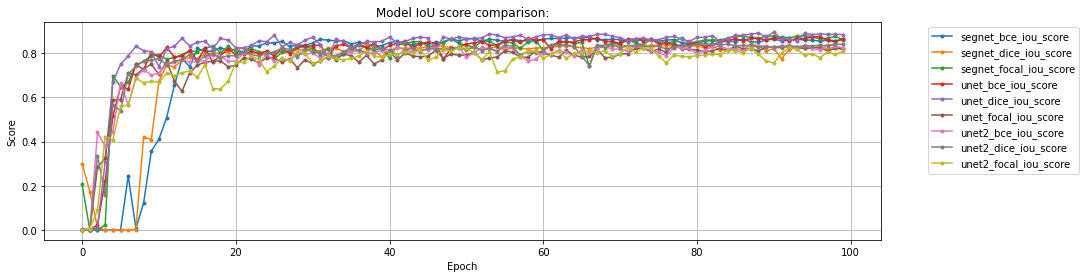

In [55]:
segnet_bce_iou_score = train_results["segnet_bce_iou_score"]
segnet_dice_iou_score = train_results["segnet_dice_iou_score"]
segnet_focal_iou_score = train_results["segnet_focal_iou_score"]
unet_bce_iou_score = train_results["unet_bce_iou_score"]
unet_dice_iou_score = train_results["unet_dice_iou_score"]
unet_focal_iou_score = train_results["unet_focal_iou_score"]
unet2_bce_iou_score = train_results["unet2_bce_iou_score"]
unet2_dice_iou_score = train_results["unet2_dice_iou_score"]
unet2_focal_iou_score = train_results["unet2_focal_iou_score"]

segnet_bce_test_score = scores_results["segnet_bce_test_score"].values[0]
segnet_dice_test_score = scores_results["segnet_dice_test_score"].values[0]
segnet_focal_test_score = scores_results["segnet_focal_test_score"].values[0]
unet_bce_test_score = scores_results["unet_bce_test_score"].values[0]
unet_dice_test_score = scores_results["unet_dice_test_score"].values[0]
unet_focal_test_score = scores_results["unet_focal_test_score"].values[0]
unet2_bce_test_score = scores_results["unet2_bce_test_score"].values[0]
unet2_dice_test_score = scores_results["unet2_dice_test_score"].values[0]
unet2_focal_test_score = scores_results["unet2_focal_test_score"].values[0]

iou_scores = {"segnet_bce_iou_score" : segnet_bce_iou_score, 
                "segnet_dice_iou_score" : segnet_dice_iou_score,
                "segnet_focal_iou_score" : segnet_focal_iou_score, 
                "unet_bce_iou_score" : unet_bce_iou_score,
                "unet_dice_iou_score" : unet_dice_iou_score, 
                "unet_focal_iou_score" : unet_focal_iou_score, 
                "unet2_bce_iou_score" : unet2_bce_iou_score, 
                "unet2_dice_iou_score" : unet2_dice_iou_score, 
                "unet2_focal_iou_score" : unet2_focal_iou_score
               }

for key, val in iou_scores.items():
    plt.plot(val, label=key, marker=".")

plt.title("Model IoU score comparison:")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.show()

При оценке качества на тестовом наборе данных лучше всех себя показала модель **Unet2**  с оценкой **~0.86**. Относительно обычного **Unet** в модели были заменены апсемплинг, даунсемплинг на сверточные слои. Также использовалась функция потери **Dice**. Хуже всех показала себя модель Unet-2 при использовании функции потерь **focal**.
<br>
По полученным данным делаем вывод, что с задачей сегментации лучше всех справилась модель **Unet2**.

In [56]:
test_scores = {"segnet_bce_test_score" : segnet_bce_test_score, 
               "segnet_dice_test_score" : segnet_dice_test_score,
               "segnet_focal_test_score" : segnet_focal_test_score, 
               "unet_bce_test_score" : unet_bce_test_score, 
               "unet_dice_test_score" : unet_dice_test_score, 
               "unet2_bce_test_score" : unet2_bce_test_score, 
               "unet2_dice_test_score" : unet2_dice_test_score, 
               "unet2_focal_test_score" : unet2_focal_test_score
              }

test_scores = dict(sorted(test_scores.items(), key=lambda x: x[1], reverse=True))

best_model_key = list(test_scores.keys())[0]
best_model_score = test_scores[best_model_key]

print("Best model is {name} with score: {score}\n".format(name=best_model_key, score=best_model_score))
print("All models scores: ")
for key, val in test_scores.items():
    print("{name}: {score}".format(name=key, score=val))

Best model is segnet_bce_test_score with score: 0.8772720992565155

All models scores: 
segnet_bce_test_score: 0.8772720992565155
unet2_dice_test_score: 0.874285626411438
segnet_focal_test_score: 0.8671290278434753
unet_bce_test_score: 0.8660197854042053
unet2_bce_test_score: 0.8530789375305176
segnet_dice_test_score: 0.8511441051959991
unet_dice_test_score: 0.8265118598937988
unet2_focal_test_score: 0.7856417298316956


По полученным данным функций потерь и оценки, делаем вывод, что лучше всего с сегментацией изображений справилась модель **UNet2**.